<a href="https://colab.research.google.com/github/Sakina8/Fruit-Clasifier-by-Saki/blob/master/Fruit-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Fruits




 Each section represents a stage along implementing an image classifier from loading and inspecting the dataset to making something working. The section descriptions contain what to do in that step.


**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Task description
Our task is to implement a deep learning classifier of fruit images. The dataset contains segmented images of 60 different fruits. We'll have to implement a convolutional network.



In [0]:
# Keras 2.3.1 has a bug in evalutation, downgrade it
%tensorflow_version 1.x
!pip install -U keras==2.2.5

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 15.2MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
# Some useful imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.image as img
%matplotlib inline
from sklearn.datasets import load_files       
from keras.utils import np_utils
import pickle
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from IPython.display import display
from PIL import Image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Using TensorFlow backend.


## Dataset preparations
First download the data and extract it:

In [0]:
!wget http://vegesm.web.elte.hu/fruits_small.zip
!unzip fruits_small.zip > /dev/null

--2020-05-13 17:10:37--  http://vegesm.web.elte.hu/fruits_small.zip
Resolving vegesm.web.elte.hu (vegesm.web.elte.hu)... 157.181.1.225
Connecting to vegesm.web.elte.hu (vegesm.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186322919 (178M) [application/zip]
Saving to: ‘fruits_small.zip’

fruits_small.zip    100%[===================>] 177.69M  3.82MB/s    in 5m 12s  

2020-05-13 17:15:50 (584 KB/s) - ‘fruits_small.zip’ saved [186322919/186322919]



This will download and extract the dataset into `/content/fruits-small`. You can inspect the files in the sidebar on the left, under the *Files* tab. The dataset contains 100x100 pixel images of fruits, grouped by classes into folders. 

Notice that the dataset does not define a validation set, you have to split it yourself. Split the training set into a training and validation set. Make sure in the validation set the classes have a similar distribution to the training set.



Now that you have set up the dataset, it's time to look at some of the images. Create a function that randomly selects 4 images and prints them with the class names.

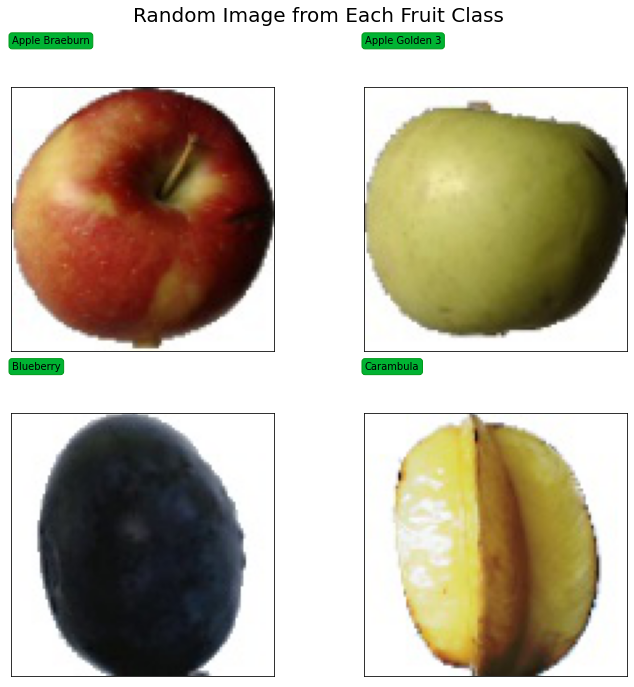

In [0]:
# ADD YOUR CODE HERE
import os
dataset = '/content/fruits-small'
train_dir = '/content/fruits-small/train'
test_dir = '/content/fruits-small/test'
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(10, 10))
fig.suptitle('Random Image from Each Fruit Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(train_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[5*i*cols + 2*j]
        except:
            break
        all_files = os.listdir(os.path.join(train_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(train_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [0]:
# Here with your permission I would like to learn more about the dataset

# define function to load train and test datasets
def load_dataset(dataset):
    data = load_files(dataset)
    fruit_files = np.array(data['filenames'])
    fruit_targets = np_utils.to_categorical(np.array(data['target']), 81)
    return fruit_files, fruit_targets

# load train and test datasets
train_files, train_targets = load_dataset('/content/fruits-small/train')
test_files, test_targets = load_dataset('/content/fruits-small/test')

# load list of fruits names
fruit_names = [item[9:] for item in sorted(glob("/content/fruits-small/train/*"))]

# print statistics about the dataset
print('There are %d total fruit categories.' % len(fruit_names))
print('There are %s total fruit images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training fruit images.' % len(train_files))
print('There are %d test fruit images.'% len(test_files))
print(train_files[:10])

There are 60 total fruit categories.
There are 40800 total fruit images.

There are 30468 training fruit images.
There are 10332 test fruit images.
['/content/fruits-small/train/Strawberry/240_100.jpg'
 '/content/fruits-small/train/Plum 3/r_252_100.jpg'
 '/content/fruits-small/train/Cherry Rainier/r_218_100.jpg'
 '/content/fruits-small/train/Potato White/96_100.jpg'
 '/content/fruits-small/train/Kaki/117_100.jpg'
 '/content/fruits-small/train/Avocado/r_168_100.jpg'
 '/content/fruits-small/train/Plum 3/r2_165_100.jpg'
 '/content/fruits-small/train/Tomato 3/r_302_100.jpg'
 '/content/fruits-small/train/Physalis with Husk/r_194_100.jpg'
 '/content/fruits-small/train/Pineapple Mini/r_12_100.jpg']


### Splitting the dataset

Notice that the dataset does not define a validation set, you have to split it ourselves. Split the training set into a training and validation set. 

### Preprocess the dataset

We need to augment the data, since we do not have many images per classes. Create an augmentation mechanism, data automatically does the following transformations during training:
- flip images horizontally
- rotates them
- performs zooming

In [0]:
import keras


datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=0.1,rescale=1./255,horizontal_flip=True,zoom_range=0.3,validation_split=0.15)

train_generator_iter = datagen.flow_from_directory(
        train_dir,target_size=(100, 100),
        batch_size=15,class_mode='categorical',
        subset='training')
val_generator_iter= datagen.flow_from_directory(train_dir,
        target_size=(100, 100),batch_size=15,
        class_mode='categorical',
        subset='validation')
test_images_iter = datagen.flow_from_directory(test_dir,
        target_size=(100, 100),  # all images will be resized to 100x100
        batch_size=15,
        class_mode = 'categorical')


Found 25934 images belonging to 60 classes.
Found 4534 images belonging to 60 classes.
Found 10332 images belonging to 60 classes.


## Training the network

Implement and train the following architecture. It has the following layers:

- A convolutional layer with 5x5 kernel and 32 filters
- A 2x2 MaxPooling layer
- Two convolutional layers with 3x3 kernels and 64 filters each
- A MaxPooling layer
- Another 3x3 convolutional layer with 128 filters, followed by a MaxPooling layer
- A fully connected layer of 512 units
- A final softmax layer

All layers have ReLU activations. Train the network for 15 epochs.

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=(5, 5), activation='relu',input_shape=(100, 100, 3)))
#model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(3, 3), activation='relu'))
#model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(filters=128,kernel_size=(3, 3), activation='relu'))
#model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(60, activation='softmax'))
 
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)  

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr = 1e-4, decay = 1e-6),
              metrics= ['acc'])

In [0]:
history = model.fit_generator(train_generator_iter,
                          epochs=15,
                          validation_data = val_generator_iter,
                          verbose=1,callbacks = [
# Early Stopping just in case the loss stops decreasing
keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





1729/1729 [==============================] - 99s 57ms/step - loss: 0.9087 - acc: 0.7356 - val_loss: 0.3661 - val_acc: 0.9071
Epoch 2/15
1729/1729 [==============================] - 84s 48ms/step - loss: 0.1416 - acc: 0.9561 - val_loss: 0.2927 - val_acc: 0.9191
Epoch 3/15
1729/1729 [==============================] - 83s 48ms/step - loss: 0.0752 - acc: 0.9773 - val_loss: 0.1925 - val_acc: 0.9539
Epoch 4/15
1729/1729 [==============================] - 83s 48ms/step - loss: 0.0538 - acc: 0.9833 - val_loss: 0.3596 - val_acc: 0.9338
Epoch 5/15
1729/1729 [==============================] - 83s 48ms/step - loss: 0.0416 - acc: 0.9878 - val_loss: 0.2493 - val_acc: 0.9440
Epoch 6/15
1729/1729 [==============================] - 82s 48ms/step - loss: 0.0335 - acc: 0.9904 - val_loss: 0.3149 - val_acc: 0.9607
Epoch 7/15
1729/1729 [==============================] - 82s 48ms/step - loss: 0.03

Now, that the model has finished training, plot the accuracy and loss over time, both for training and validation data:

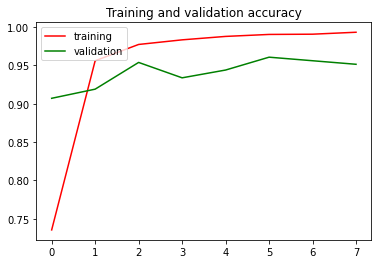

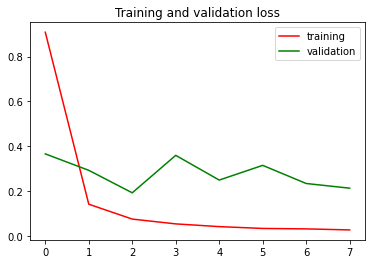

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(['training', 'validation'], loc='upper left')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(['training', 'validation'], loc='upper right')

plt.show()

Finally, calculate the performance of our model on the test set:

In [0]:
#
pred=model.predict_generator(test_images_iter, steps=500, 
                            callbacks=None, max_queue_size=10,
                            workers=1, use_multiprocessing=False, 
                            verbose=0)                                              

In [0]:
loss,acc = model.evaluate_generator(generator=test_images_iter, steps=500, use_multiprocessing=False)
print('test loss: {}'.format(loss))
print('test accuracy: {:.2%}'.format(acc))

test loss: 0.24981442901473794
test accuracy: 95.36%


('Tamarillo', 55, '100.00%')


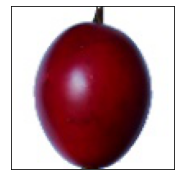

('Plum', 47, '100.00%')


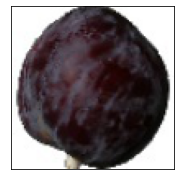

('Potato White', 51, '100.00%')


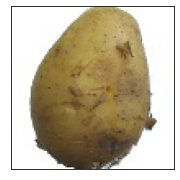

('Pineapple Mini', 46, '100.00%')


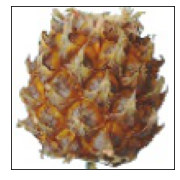

In [0]:
#Checking the test accuracy
List=['/content/fruits-small/test/Tamarillo/22_100.jpg',
      '/content/fruits-small/test/Plum/38_100.jpg',
      '/content/fruits-small/test/Potato White/109_100.jpg',
      '/content/fruits-small/test/Pineapple Mini/122_100.jpg']

for i in List:

  loaded_image = keras.preprocessing.image.load_img(path=i, target_size=(100,100,3))
  img_array = keras.preprocessing.image.img_to_array(loaded_image) / 255
  imag_array = np.expand_dims(img_array, axis = 0)
  predictions = model.predict(imag_array)
  classidx = np.argmax(predictions[0])
  label = list(train_generator_iter.class_indices.keys())[classidx]
  pred= ["{:.2f}%".format(j * 100) for j in predictions[0] ]
  print((label, classidx, pred[classidx])) 

  plt.figure(figsize=(3,3))
  plt.imshow(img_array)
  #title=a[i]+": "+b[ran]
  #plt.title(title)
  plt.xticks([])
  plt.yticks([])
  plt.show()